#### By: Peyman Shahidi
#### Created: Nov 3, 2025
#### Last Edit: Dec 6, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT'
output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Frequent Tasks Analysis or All Tasks Switch

In [4]:
frequent_tasks_analysis = False

# 1) Read O*NET Dataset

In [5]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


# 2) Read and Merge with Eloundou et al.'s AI Exposure Dataset

In [6]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")

Number of rows in GPTs full labels dataset: 19,265


In [7]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


# 3) Read and Merge with Anthropic's AI Use Dataset

Number of rows before filtering: 3,364
Number of rows after filtering: 2,298


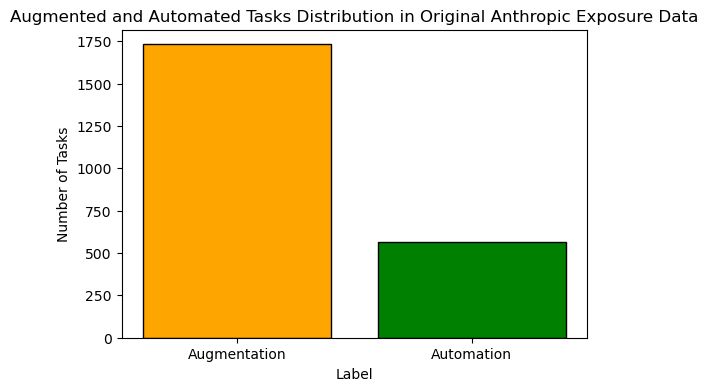

Detailed Label Distribution:
Automation  :     566 tasks
Augmentation:   1,732 tasks


In [8]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
print(f"Number of rows before filtering: {len(anthropic_exposure):,}")
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)
print(f"Number of rows after filtering: {len(anthropic_exposure):,}")

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['orange', 'green'], edgecolor='black')
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()


# Print detailed statistics
print("Detailed Label Distribution:")
print("=" * 40)
for label in ['Automation', 'Augmentation']:
    count = label_counts.get(label, 0)
    print(f"{label:12}: {count:7,} tasks")
print("=" * 40)

In [9]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

# Drop temporary columns used for merging
merged_data = merged_data.drop(columns=['task_normalized', 'task_name'])

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


# 4) Read and Merge with GPT 5-o Mini's Task Sequence Data

In [10]:
if not frequent_tasks_analysis:
    # Read task sequence data
    # Go through computed_objects/tasks_sequences and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

else:
    # Modify output paths for frequent tasks analysis
    output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT_frequent'
    os.makedirs(output_data_path, exist_ok=True)
    output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT_frequent"
    os.makedirs(output_plot_path, exist_ok=True)
    
    # Read task sequence data for frequent tasks
    # Go through computed_objects/tasks_sequences_frequent and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences_frequent') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences_frequent/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")


    # Define frequency importance threshold (in %):
    freq_importance_threshold = 65

    # Filter tasks based on frequency importance threshold
    merged_data['frequent_task'] = merged_data['FT_Daily'] + merged_data['FT_Several times daily'] + merged_data['FT_Hourly or more']
    print(f"Total tasks before filtering: {len(merged_data)}")

    # Length of ONET for different filtering thresholds:
    print("Length of ONET for different frequency importance thresholds:")
    for threshold in [50, 60, 70, 80, 90]:
        filtered_merged_data = merged_data[merged_data['frequent_task'] >= threshold]
        print(f"  - Threshold {threshold}%: {len(filtered_merged_data)} tasks")


    merged_data = merged_data[merged_data['frequent_task'] >= freq_importance_threshold].reset_index(drop=True)
    print(f"Total tasks after filtering infrequent ones: {len(merged_data)}")

    # Remove occupations with three or less frequent tasks
    frequent_tasks_per_occupation_threshold = 3
    occupation_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
    valid_occupations = occupation_task_counts[occupation_task_counts >= frequent_tasks_per_occupation_threshold].index
    merged_data = merged_data[merged_data['O*NET-SOC Code'].isin(valid_occupations)].reset_index(drop=True)

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

Task sequence data shape: (17926, 5)
Columns in task sequence: ['Task Position', 'Task Title', 'Task ID', 'O*NET-SOC Code', 'Occupation Title']


In [11]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [12]:
# Sort values of merged data before saving
merged_data = merged_data.sort_values(by=['O*NET-SOC Code', 'Task Position'])

# Save merged dataset
os.makedirs(output_data_path, exist_ok=True)
merged_data.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT.csv', index=False)

merged_data.head()

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Position,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,...,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,automation,augmentation,label
30,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",1,Core,5,2.12,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.36,0.53,Augmentation
24,11-1011.00,Chief Executives,8848,Direct or conduct studies or research on issue...,2,Core,5,0.78,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E1,NaN,NaN,Manual
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,3,Core,5,9.22,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.31,0.66,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",4,Core,5,9.49,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,0.25,0.61,Augmentation
10,11-1011.00,Chief Executives,8833,"Preside over, or serve on, boards of directors...",5,Core,5,1.46,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,NaN,NaN,Manual


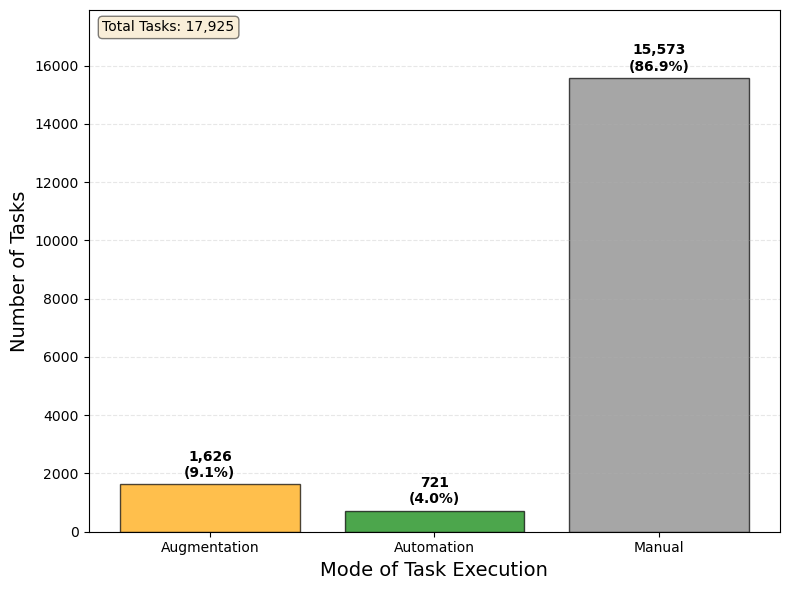

Detailed Label Distribution:
Manual      :  15,573 tasks ( 86.9%)
Automation  :     721 tasks (  4.0%)
Augmentation:   1,626 tasks (  9.1%)
Total       :  17,925 tasks (100.0%)


In [14]:
# Plot histogram of all three label values in a single histogram
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get the distribution of all label values
label_counts = merged_data.drop_duplicates(subset=['Task ID'])['label'].value_counts().sort_index()

# Define colors for each category
colors = {'Automation': 'green', 'Augmentation': 'orange', 'Manual': 'grey'}

# Create the bar plot
bars = ax.bar(label_counts.index, label_counts.values, 
              color=[colors[label] for label in label_counts.index], 
              alpha=0.7, edgecolor='black', linewidth=1)

# Add value labels on top of each bar
for i, (label, count) in enumerate(label_counts.items()):
    percentage = (count / len(merged_data)) * 100
    ax.text(i, count + max(label_counts.values) * 0.01, 
            f'{count:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

# Customize the plot
# ax.set_title('Distribution of Task Labels in Merged Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Mode of Task Execution', fontsize=14)
ax.set_ylabel('Number of Tasks', fontsize=14)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Set y-axis limit with some padding
ax.set_ylim(0, max(label_counts.values) * 1.15)

# Add total count in the plot
total_tasks = len(merged_data)
ax.text(0.02, 0.98, f'Total Tasks: {total_tasks:,}', 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{output_plot_path}/all_labels_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("Detailed Label Distribution:")
print("=" * 40)
for label in ['Manual', 'Automation', 'Augmentation']:
    count = label_counts.get(label, 0)
    percentage = (count / total_tasks) * 100
    print(f"{label:12}: {count:7,} tasks ({percentage:5.1f}%)")
print("=" * 40)
print(f"{'Total':12}: {total_tasks:7,} tasks (100.0%)")

# Randomization Functions for Task-Occupation Assignments and Task Positions within Occupations

In [15]:
# Functions to generate hierarchical mappings and to reshuffle pairings
import warnings


def generate_mappings(df):
    """Generate mapping tables between successive hierarchy levels from the provided dataframe.
    Returns a dict with mapping DataFrames (may be empty DataFrames if required columns are missing).
    Expected column names (if present) used to create mappings:
      - Task level: 'Task ID', 'Task Title'
      - Occupation level: 'O*NET-SOC Code', 'Occupation Title'
      - Detailed/Broad/Minor/Major: 'Detailed_Occupation_Code','Detailed_Occupation_Title',
        'Broad_Occupation_Code','Broad_Occupation_Title',
        'Minor_Group_Code','Minor_Group_Title',
        'Major_Group_Code','Major_Group_Title'
    """
    mappings = {}

    # Helper to safe drop-duplicates for a mapping if columns exist
    def _make_map(cols):
        if all(c in df.columns for c in cols):
            return df[list(cols)].drop_duplicates().reset_index(drop=True)
        else:
            return pd.DataFrame(columns=cols)

    mappings['task_to_occ'] = _make_map(('Task ID','Task Title','O*NET-SOC Code','Occupation Title'))
    mappings['occ_to_detailed'] = _make_map(('O*NET-SOC Code','Occupation Title','Detailed_Occupation_Code','Detailed_Occupation_Title'))
    mappings['detailed_to_broad'] = _make_map(('Detailed_Occupation_Code','Detailed_Occupation_Title','Broad_Occupation_Code','Broad_Occupation_Title'))
    mappings['detailed_to_minor'] = _make_map(('Detailed_Occupation_Code','Detailed_Occupation_Title','Minor_Group_Code','Minor_Group_Title'))
    mappings['minor_to_major'] = _make_map(('Minor_Group_Code','Minor_Group_Title','Major_Group_Code','Major_Group_Title'))

    return mappings


def shuffle_pairing(df, from_keys, to_keys, seed=42, require_one_to_one=True, replace=True, preserve_counts=False):
    """Shuffle (reassign) the values in 'to_keys' across unique groups defined by 'from_keys'.

    Parameters:
      - df: source DataFrame
      - from_keys: list of column names defining the groups to reassign (left side)
      - to_keys: list of column names being reassigned (right side)
      - seed: RNG seed for reproducibility
      - require_one_to_one: if True, require number of unique `from` groups == number of unique `to` groups and raise otherwise
      - replace: if True, sampling is done with replacement when counts differ; if False, sampling is done without replacement whenever possible
      - preserve_counts: if True, preserve the original number of tasks assigned to each `to` group (occupation) by constructing a repeated pool of occupations equal to the original counts, then randomly assigning to `from` groups

    Behavior and notes:
      - Creates a new DataFrame (copy) with the to_keys replaced by randomly reassigned values.
      - Moves occupation-level columns (wage columns and 'Job Zone' if present) together with the new to_keys assignment.
      - Keeps task-level columns (Task Type, Task_Time_Percentage, FT_* etc.) attached to the task.
      - If require_one_to_one is True and the number of unique from groups != unique to groups, a ValueError is raised.
      - If require_one_to_one is False and replace is False but n_from > n_to, a ValueError is raised because sampling without replacement is impossible.
      - If preserve_counts is True, the algorithm preserves the counts of tasks per `to` group from the original dataframe.
    """
    rng = np.random.RandomState(seed)

    # Basic validation
    missing = [c for c in from_keys + to_keys if c not in df.columns]
    if missing:
        raise ValueError(f'Missing required columns in dataframe: {missing}')

    # Identify optional Major group columns. If present, assignment will be constrained within these groups.
    major_cols = [c for c in ['Major_Group_Code', 'Major_Group_Title'] if c in df.columns]

    # Identify occupation-level (to-level) variables that should move with the to_keys assignment
    wage_cols = [c for c in df.columns if any(k in c.lower() for k in ['wage', 'hourly', 'annual', 'mean', 'median', 'salary', 'earnings'])]
    job_zone_col = 'Job Zone' if 'Job Zone' in df.columns else None
    occ_level_extra = wage_cols + ([job_zone_col] if job_zone_col else [])
    # keep only existing cols
    occ_level_extra = [c for c in occ_level_extra if c in df.columns]

    # representative to-level table (one row per unique to_keys) and include major cols when available
    to_rep_cols = list(to_keys) + occ_level_extra + major_cols
    to_rep = df[to_rep_cols].drop_duplicates(subset=to_keys).reset_index(drop=True)

    # Unique from-groups (these are what we'll map from) and, if majors exist, include their major group info
    unique_from = df[from_keys].drop_duplicates().reset_index(drop=True)
    if major_cols:
        unique_from_major = df[from_keys + major_cols].drop_duplicates().reset_index(drop=True)
    else:
        unique_from_major = unique_from.copy()

    # Helper to perform assignment inside a specific partition (major group or overall)
    def _assign_within_partition(u_from, to_rep_part, counts_part=None):
        n_from_part = len(u_from)
        n_to_part = len(to_rep_part)

        if preserve_counts and counts_part is not None:
            # repeat rows according to counts to produce a pool of length n_from_part
            to_rep_counts = to_rep_part.merge(counts_part, on=list(to_keys), how='left')
            to_rep_counts['__count'] = to_rep_counts['__count'].fillna(0).astype(int)

            if to_rep_counts['__count'].sum() != n_from_part:
                raise ValueError('Internal error: repeated to-group pool size does not match number of unique from groups in partition')

            assigned_pool = to_rep_counts.loc[to_rep_counts.index.repeat(to_rep_counts['__count'])].reset_index(drop=True)
            perm = rng.permutation(len(assigned_pool))
            assigned_to_part = assigned_pool.iloc[perm].reset_index(drop=True)
            # ensure assigned_to_part has at least the same columns as to_rep_part
            for col in to_rep_part.columns:
                if col not in assigned_to_part.columns:
                    assigned_to_part[col] = pd.NA
            assigned_to_part = assigned_to_part[list(to_rep_part.columns)]
            return assigned_to_part

        # No preserve_counts: decide how to sample/permute within the partition
        if n_from_part == n_to_part:
            permuted_idx = rng.permutation(n_to_part)
            return to_rep_part.iloc[permuted_idx].reset_index(drop=True)
        else:
            if not replace:
                if n_from_part > n_to_part:
                    raise ValueError(f'Cannot sample without replacement in partition: number of from groups ({n_from_part}) > number of to groups ({n_to_part}).')
                sampled_idx = rng.choice(n_to_part, size=n_from_part, replace=False)
                return to_rep_part.iloc[sampled_idx].reset_index(drop=True)
            else:
                sampled_idx = rng.randint(0, n_to_part, size=n_from_part)
                return to_rep_part.iloc[sampled_idx].reset_index(drop=True)

    # If preserve_counts is requested and majors exist, compute counts per (to_keys + major_cols)
    if preserve_counts:
        count_cols = list(to_keys) + major_cols if major_cols else list(to_keys)
        # protect against missing columns in df when building counts
        available_count_cols = [c for c in from_keys + count_cols if c in df.columns]
        counts = df[available_count_cols].drop_duplicates()
        # If some count columns are missing (unlikely because we validated to_keys), group only by available to_keys
        groupby_cols = [c for c in count_cols if c in df.columns]
        counts = counts.groupby(groupby_cols).size().reset_index(name='__count')

    assigned_to_parts = []
    assigned_from_parts = []

    if major_cols:
        # Partition assignment by major group: ensure we only assign to 'to' rows that share the same major group
        # Group unique_from_major by major columns
        grouped = unique_from_major.groupby(major_cols, dropna=False)
        for major_vals, u_from_group in grouped:
            # Build mask to select matching to_rep rows for this major group
            mask = True
            if isinstance(major_vals, tuple):
                for col, val in zip(major_cols, major_vals):
                    mask = mask & (to_rep[col] == val)
            else:
                mask = (to_rep[major_cols[0]] == major_vals)

            to_rep_part = to_rep[mask].reset_index(drop=True)

            if len(u_from_group) == 0:
                continue

            # counts for this partition if preserve_counts requested
            counts_part = None
            if preserve_counts:
                # filter counts to the partition's major values
                if major_cols:
                    # build boolean mask on counts
                    counts_mask = True
                    if isinstance(major_vals, tuple):
                        for col, val in zip(major_cols, major_vals):
                            counts_mask = counts_mask & (counts[col] == val)
                    else:
                        counts_mask = (counts[major_cols[0]] == major_vals)
                    counts_part = counts[counts_mask].reset_index(drop=True)
                else:
                    counts_part = counts.copy()

            assigned_to_part = _assign_within_partition(u_from_group[list(from_keys)], to_rep_part, counts_part=counts_part)
            assigned_to_parts.append(assigned_to_part)
            assigned_from_parts.append(u_from_group[list(from_keys)])

        # Concatenate parts to produce full assigned_to and mapping
        if len(assigned_to_parts) == 0:
            assigned_to = pd.DataFrame(columns=to_rep.columns)
        else:
            assigned_to = pd.concat(assigned_to_parts, ignore_index=True)

        assigned_from = pd.concat(assigned_from_parts, ignore_index=True)
        assigned_to.columns = to_rep.columns
        mapping = pd.concat([assigned_from.reset_index(drop=True), assigned_to.reset_index(drop=True)], axis=1)

    else:
        # No major partition constraints: original behavior
        unique_to = to_rep[list(to_keys)].drop_duplicates().reset_index(drop=True)
        n_from = len(unique_from)
        n_to = len(unique_to)

        if require_one_to_one and n_from != n_to:
            raise ValueError(f'One-to-one reassignment requested but number of unique from groups ({n_from}) != unique to groups ({n_to}). Set require_one_to_one=False to allow sampling (with or without replacement).')

        if preserve_counts:
            to_rep_counts = to_rep.merge(counts, on=list(to_keys), how='left')
            to_rep_counts['__count'] = to_rep_counts['__count'].fillna(0).astype(int)
            if to_rep_counts['__count'].sum() != n_from:
                raise ValueError('Internal error: repeated to-group pool size does not match number of unique from groups')
            assigned_pool = to_rep_counts.loc[to_rep_counts.index.repeat(to_rep_counts['__count'])].reset_index(drop=True)
            perm = rng.permutation(len(assigned_pool))
            assigned_to = assigned_pool.iloc[perm].reset_index(drop=True)
            # ensure assigned_to has at least the same columns as to_rep
            for col in to_rep.columns:
                if col not in assigned_to.columns:
                    assigned_to[col] = pd.NA
            assigned_to = assigned_to[list(to_rep.columns)]
        else:
            if n_from == n_to:
                permuted_idx = rng.permutation(n_to)
                assigned_to = to_rep.iloc[permuted_idx].reset_index(drop=True)
            else:
                if not replace:
                    if n_from > n_to:
                        raise ValueError(f'Cannot sample without replacement: number of from groups ({n_from}) > number of to groups ({n_to}). Either set replace=True or require_one_to_one=True when counts match.')
                    sampled_idx = rng.choice(n_to, size=n_from, replace=False)
                    assigned_to = to_rep.iloc[sampled_idx].reset_index(drop=True)
                else:
                    sampled_idx = rng.randint(0, n_to, size=n_from)
                    assigned_to = to_rep.iloc[sampled_idx].reset_index(drop=True)

        assigned_to.columns = to_rep.columns
        mapping = pd.concat([unique_from.reset_index(drop=True), assigned_to.reset_index(drop=True)], axis=1)

    # Now create a copy of df and replace to_keys + occ_level_extra by merging onto mapping via from_keys
    df_new = df.copy()
    replace_cols = list(to_keys) + occ_level_extra
    df_new = df_new.merge(mapping, on=from_keys, how='left', suffixes=(None, '_new'))

    # For each replaced column, take the _new if present
    for col in replace_cols:
        new_col = col + '_new'
        if new_col in df_new.columns:
            df_new[col] = df_new[new_col]
            df_new = df_new.drop(columns=[new_col])

    # Ensure 'Major_Group_Code' and 'Major_Group_Title' exist in both df_new and mapping so downstream
    # selection like df[cols_to_keep] won't raise KeyError. If missing, add them as NA.
    for col in ['Major_Group_Code', 'Major_Group_Title']:
        if col not in df_new.columns:
            df_new[col] = pd.NA
        if 'mapping' in locals() and col not in mapping.columns:
            mapping[col] = pd.NA

    # Clean up any accidental duplicate columns from merge (safety)
    df_new = df_new.loc[:, ~df_new.columns.duplicated()]

    # Sort values before returning output
    df_new = df_new.sort_values(by=['O*NET-SOC Code', 'Task Position'])

    return df_new, mapping


# New helper: reassign Task Position within each occupation
def reassign_task_positions_within_occupation(df, randomize_positions=False, seed=42, occ_key='O*NET-SOC Code'):
    """Reassign the 'Task Position' values within each occupation (grouped by occ_key).

    If randomize_positions is True, assign a random permutation of 1..n to tasks within each occupation using the provided seed.
    If False, sort tasks within each occupation by 'Task ID' and assign Task Position = 1..n in that order.

    Returns a new DataFrame (copy) with updated 'Task Position' column (integers starting at 1).
    """
    rng = np.random.RandomState(seed)

    if 'Task ID' not in df.columns:
        raise ValueError("DataFrame must contain 'Task ID' column to deterministically assign positions when randomize_positions=False")

    def _process_group(g):
        g = g.copy()
        n = len(g)
        if n == 0:
            return g
        if randomize_positions:
            # deterministic random permutation of positions 1..n
            perm = rng.permutation(n) + 1
            g['Task Position'] = perm
        else:
            # sort by Task ID and assign sequential positions 1..n
            g = g.sort_values('Task ID')
            g['Task Position'] = list(range(1, n+1))
        return g

    # apply per occupation, preserve original order of other columns
    out = df.groupby(occ_key, group_keys=False).apply(_process_group).reset_index(drop=True)

    # Sort values before returning output
    out = out.sort_values(by=['O*NET-SOC Code', 'Task Position'])
    return out

In [59]:
# ## Example usage of the reshuffling functions

# # Create mappings and then shuffle occupations across tasks
# mappings = generate_mappings(merged_data)
# print('Mappings generated:')
# for k,v in mappings.items():
#     print(f' - {k}: {len(v):,} rows (cols: {list(v.columns)})')

# # Shuffle O*NET occupations across Task IDs
# from_keys = ['Task ID','Task Title']
# to_keys = ['Detailed_Occupation_Code','Detailed_Occupation_Title']

# # Choose a seed that will be used for both the occupation shuffle and the task-position reassignment
# seed = 42

# # Scenario A: preserve number of tasks within occupation (preserve_counts=True)
# shuffled_preserve, mapping_preserve = shuffle_pairing(merged_data, 
#                                                       from_keys=from_keys, to_keys=to_keys, 
#                                                       seed=seed, 
#                                                       require_one_to_one=False, replace=False, preserve_counts=True)
# # Reassign Task Position within each occupation according to the switch
# shuffled_preserve = reassign_task_positions_within_occupation(shuffled_preserve, randomize_positions=True, seed=seed)

# # shuffled_preserve.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT_shuffled_preserve_counts.csv', index=False)

# # Scenario B: do not preserve number of tasks within occupations (default / previous behavior)
# shuffled, new_mapping = shuffle_pairing(merged_data, 
#                                         from_keys=from_keys, to_keys=to_keys, 
#                                         seed=seed, 
#                                         require_one_to_one=False, replace=True, preserve_counts=False)
# # Reassign Task Position within each occupation according to the switch
# shuffled = reassign_task_positions_within_occupation(shuffled, randomize_positions=True, seed=seed)
# # save the result
# # shuffled.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT_shuffled.csv', index=False)


# # Scenario C: only change the task positions within each occupation without changing the occupation assignments
# shuffled_only_positions = reassign_task_positions_within_occupation(merged_data, randomize_positions=True, seed=seed)
# # save the result
# # shuffled_only_positions.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT_shuffled_only_positions_taskPosRandom.csv', index=False)

# print(f'Merged Data Unique Tasks: {merged_data["Detailed_Occupation_Code"].nunique():,}')
# print(f'Shuffled Preserve Unique Tasks: {shuffled_preserve["Detailed_Occupation_Code"].nunique():,}')
# print(f'Shuffled Unique Tasks: {shuffled["Detailed_Occupation_Code"].nunique():,}')
# print(f'Shuffled Only Positions Unique Tasks: {shuffled_only_positions["Detailed_Occupation_Code"].nunique():,}')

### Create 1000 Reshuffled Datasets:
1) Reshuffle Task-Occupation Assignments while preserving Occupation Length
2) Reshuffle Task-Occupation Assignments changing Occupation Length

In [60]:
import numpy as np

# Create mappings and then shuffle occupations across tasks
mappings = generate_mappings(merged_data)
print('Mappings generated:')
for k,v in mappings.items():
    print(f' - {k}: {len(v):,} rows (cols: {list(v.columns)})')

# Shuffle O*NET occupations across Task IDs
from_keys = ['Task ID','Task Title']
to_keys = ['Detailed_Occupation_Code','Detailed_Occupation_Title']

Mappings generated:
 - task_to_occ: 17,920 rows (cols: ['Task ID', 'Task Title', 'O*NET-SOC Code', 'Occupation Title'])
 - occ_to_detailed: 872 rows (cols: ['O*NET-SOC Code', 'Occupation Title', 'Detailed_Occupation_Code', 'Detailed_Occupation_Title'])
 - detailed_to_broad: 758 rows (cols: ['Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Broad_Occupation_Code', 'Broad_Occupation_Title'])
 - detailed_to_minor: 758 rows (cols: ['Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Minor_Group_Code', 'Minor_Group_Title'])
 - minor_to_major: 110 rows (cols: ['Minor_Group_Code', 'Minor_Group_Title', 'Major_Group_Code', 'Major_Group_Title'])


In [61]:
# 1) Reshuffle task assignments 1000 times while preserving counts
np.random.seed(42)
num_iterations = 1000

output_dir = f'{output_data_path}/taskReshuffled_preserveCounts'
os.makedirs(output_dir, exist_ok=True)

cols_to_keep = ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title',
                'Task Position', 'Task Type', 
                'Major_Group_Code', 'Major_Group_Title', 
                'Minor_Group_Code', 'Minor_Group_Title',
                'Broad_Occupation_Code', 'Broad_Occupation_Title',
                'Detailed_Occupation_Code', 'Detailed_Occupation_Title',
                'gpt4_exposure', 'human_labels', 
                'automation', 'augmentation', 'label']

for i in range(num_iterations):
    file_path = f'{output_dir}/ONET_Eloundou_Anthropic_GPT_iter{i+1}.csv'
    if os.path.exists(file_path):
        continue  # Skip iteration if file already exists

    seed = 42 + i  # Different seed for each iteration
    shuffled_preserve, mapping_preserve = shuffle_pairing(merged_data, 
                                                          from_keys=from_keys, to_keys=to_keys, 
                                                          seed=seed, 
                                                          require_one_to_one=False, replace=False, preserve_counts=True)
    # Reassign Task Position within each occupation according to the switch
    shuffled_preserve = reassign_task_positions_within_occupation(shuffled_preserve, randomize_positions=True, seed=seed)
    
    # Keep only the necessary columns
    shuffled_preserve = shuffled_preserve[cols_to_keep]

    # Save the result with iteration number in the filename
    shuffled_preserve.to_csv(file_path, index=False)
    
    # Print progress
    if i % 50 == 0:
        print(f"Saved reshuffled dataset for iteration {i+1}")

In [62]:
# 2) Reshuffle task assignments 1000 times changing occupation length
np.random.seed(42)
num_iterations = 1000

output_dir = f'{output_data_path}/taskReshuffled_changeCounts'
os.makedirs(output_dir, exist_ok=True)

cols_to_keep = ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title',
                'Task Position', 'Task Type', 
                'Major_Group_Code', 'Major_Group_Title', 
                'Minor_Group_Code', 'Minor_Group_Title',
                'Broad_Occupation_Code', 'Broad_Occupation_Title',
                'Detailed_Occupation_Code', 'Detailed_Occupation_Title',
                'gpt4_exposure', 'human_labels', 
                'automation', 'augmentation', 'label']

for i in range(num_iterations):
    file_path = f'{output_dir}/ONET_Eloundou_Anthropic_GPT_iter{i+1}.csv'
    if os.path.exists(file_path):
        continue  # Skip iteration if file already exists

    seed = 42 + i  # Different seed for each iteration
    shuffled_preserve, mapping_preserve = shuffle_pairing(merged_data, 
                                                          from_keys=from_keys, to_keys=to_keys, 
                                                          seed=seed, 
                                                          require_one_to_one=False, replace=True, preserve_counts=False)
    # Reassign Task Position within each occupation according to the switch
    shuffled_preserve = reassign_task_positions_within_occupation(shuffled_preserve, randomize_positions=True, seed=seed)
    
    # Keep only the necessary columns
    shuffled_preserve = shuffled_preserve[cols_to_keep]

    # Save the result with iteration number in the filename
    shuffled_preserve.to_csv(file_path, index=False)
    
    # Print progress
    if i % 50 == 0:
        print(f"Saved reshuffled dataset for iteration {i+1}")